In [1]:
!pip install resampy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense , Activation , Dropout , SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, ReLU, Flatten
from keras.optimizers import Adam

from keras import backend as keras_backend
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
import random
import math

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [5]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [6]:
len(df)

3480

In [7]:
def get_duration(file_name):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [8]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [00:56, 61.08it/s]


In [9]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [10]:
len(sorted_df)

3471

In [11]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [12]:
appended = []
for i in range(1,4):
    appended.append(sorted_df[sorted_df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,332,326
1,fold2,496,329,329
2,fold3,499,332,332


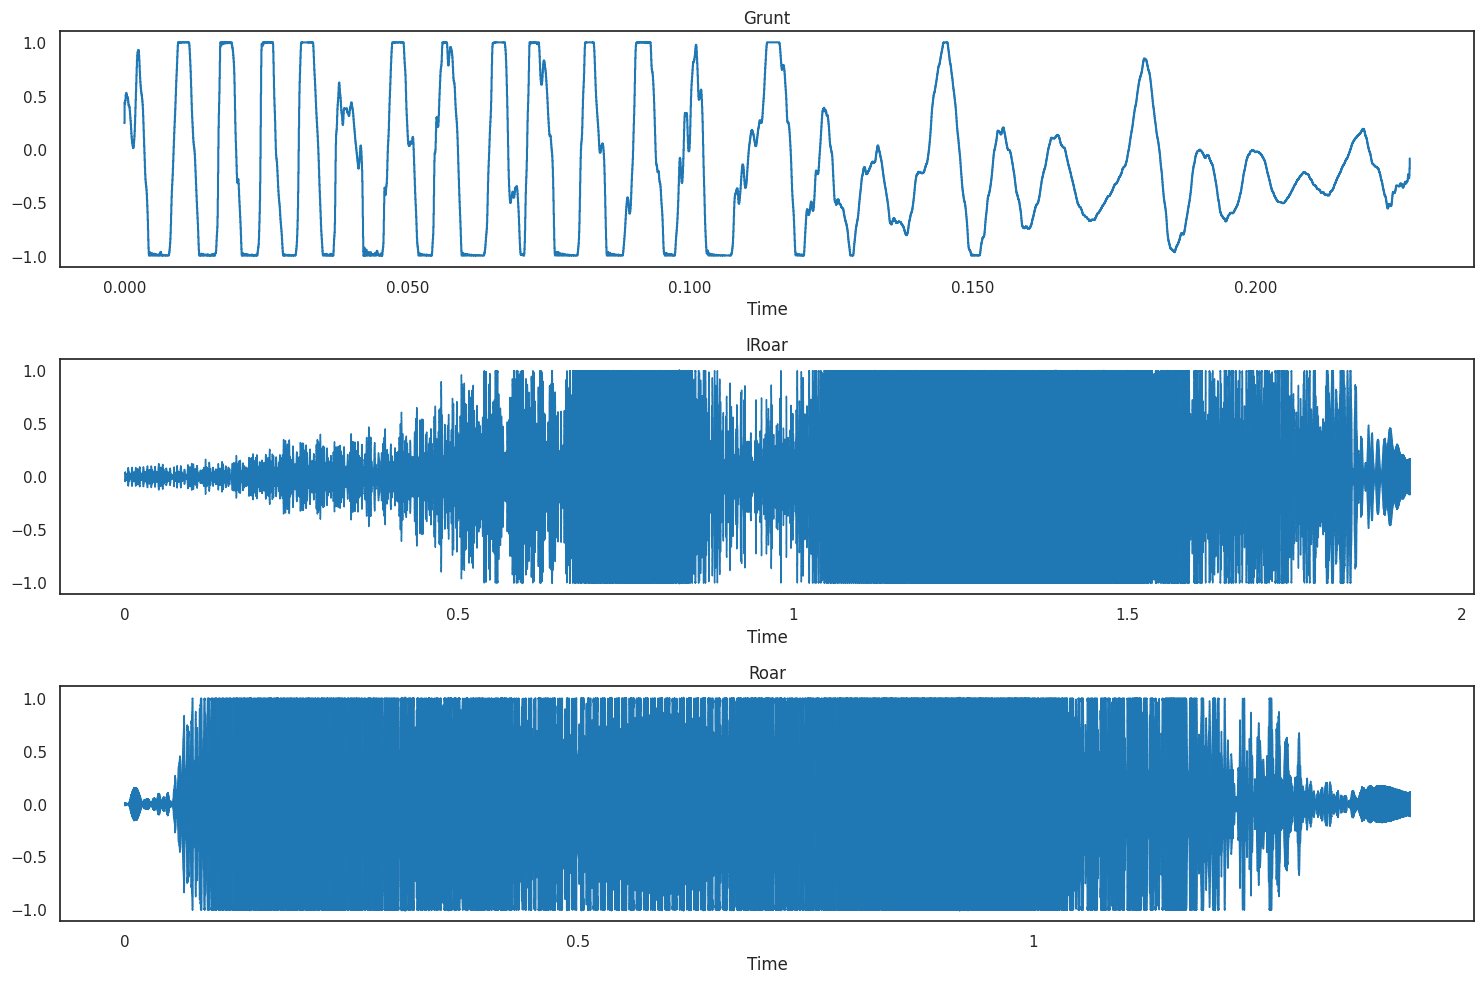

In [13]:
# Randomly select one sample of each class
random_samples = sorted_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

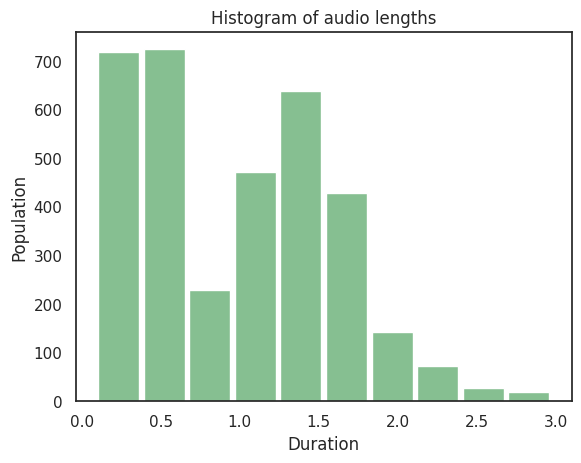

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 152
Lower than 2 but greater than 1 seconds: 1601
Lower than 1 seconds: 1718


In [14]:
plt.hist(sorted_df['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = sorted_df['duration'][(sorted_df['duration'] > 3)].count()
gt_2sec = sorted_df['duration'][(sorted_df['duration'] > 2) & (sorted_df['duration'] < 3)].count()
lt_2sec = sorted_df['duration'][(sorted_df['duration'] > 1) & (sorted_df['duration'] < 2)].count()
lt_1sec = sorted_df['duration'][sorted_df['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [15]:
# Feature extraction using librosa

data = []
labels = []

start = 0
end = 0

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(sorted_df))):
    fold_no=str(sorted_df.iloc[i]["fold"])
    file=sorted_df.iloc[i]["slice_file_name"]
    label=sorted_df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)
    if sorted_df.iloc[i]["class"] == "IRoar":
      start = 22000
      end= 26000
    elif sorted_df.iloc[i]["class"] == "Roar":
      start = 7000
      end= 11000
    elif sorted_df.iloc[i]["class"] == "Grunt":
      start = 2000
      end= 6000
    mfccs = np.mean(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=40).T,axis=0)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y_trimmed[start:end], sr=sr, n_mels=40,fmax=8000).T,axis=0)
    chroma_stft=np.mean(librosa.feature.chroma_stft(y=y_trimmed[start:end], sr=sr,n_chroma=40).T,axis=0)

    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
    data.append(features)
    labels.append(label)

  0%|          | 1/3471 [00:00<10:13,  5.65it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
  0%|          | 7/3471 [00:00<02:51, 20.18it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(
  1%|          | 25/3471 [00:00<01:56, 29.46it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=784
  warnings.warn(
  1%|▏         | 50/3471 [00:01<01:36, 35.48it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1981
  warnings.warn(
  2%|▏         | 54/3471 [00:01<01:39, 34.31it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0

In [16]:
data=np.array(data)
labels=np.array(labels)

In [17]:
data.shape, labels.shape

((3471, 40, 3), (3471,))

In [18]:
# Shuffle the data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [19]:
# Convert data to NumPy arrays with the proper dimensions for CNN input
data = data[..., np.newaxis]

In [20]:
data.shape

(3471, 40, 3, 1)

In [21]:
model=Sequential()
#adding layers and forming the model
model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="elu",input_shape=(40,3,1)))
model.add(MaxPooling2D(padding="same"))
model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="elu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256,activation="elu"))
model.add(Dropout(0.3))
model.add(Dense(512,activation="elu"))
model.add(Dropout(0.3))
model.add(Dense(3,activation="softmax"))

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Split the data into training and testing sets
split_ratio = 0.6
split_index = int(len(data) * split_ratio)
X_train, X_test = data[:split_index], data[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

In [25]:
batch_size = 50

In [26]:
# Function to calculate the size of a NumPy array in bytes
def get_size_in_bytes(arr):

    return arr.nbytes

In [27]:
# Training and sequential testing
start_time = time.time()
total_data_read_bytes = 0  # Counter to keep track of data read in bytes across all epochs

for epoch in range(30):  # Adjust the number of epochs as needed
    # Use model.fit to train the model with batch_size and verbose set
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1)

    # Calculate the number of samples read in this epoch
    num_samples_read_bytes = get_size_in_bytes(X_train)

    total_data_read_bytes += num_samples_read_bytes  # Update the total count

    # Make predictions on the entire test set
    predict_x=model.predict(X_test)
    y_pred=np.argmax(predict_x,axis=1)

    # Calculate accuracy for early classification
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Epoch {epoch + 1}: Early Accuracy = {accuracy:.2f}, Data Read in Epoch (bytes) = {num_samples_read_bytes}, Total Data Read (bytes) = {total_data_read_bytes}')

    # Check for early stopping based on a predefined accuracy threshold
    if accuracy >= 0.80:  # Adjust the threshold as needed
        break

end_time = time.time()

print(f'Training and Sequential Testing Time: {end_time - start_time:.2f} seconds')

44/44 [==============================] - 1s 11ms/step
Epoch 1: Early Accuracy = 0.70, Data Read in Epoch (bytes) = 999360, Total Data Read (bytes) = 999360
44/44 [==============================] - 0s 11ms/step
Epoch 2: Early Accuracy = 0.78, Data Read in Epoch (bytes) = 999360, Total Data Read (bytes) = 1998720
44/44 [==============================] - 1s 16ms/step
Epoch 3: Early Accuracy = 0.75, Data Read in Epoch (bytes) = 999360, Total Data Read (bytes) = 2998080
44/44 [==============================] - 0s 11ms/step
Epoch 4: Early Accuracy = 0.75, Data Read in Epoch (bytes) = 999360, Total Data Read (bytes) = 3997440
44/44 [==============================] - 1s 14ms/step
Epoch 5: Early Accuracy = 0.76, Data Read in Epoch (bytes) = 999360, Total Data Read (bytes) = 4996800
44/44 [==============================] - 0s 11ms/step
Epoch 6: Early Accuracy = 0.77, Data Read in Epoch (bytes) = 999360, Total Data Read (bytes) = 5996160
44/44 [==============================] - 0s 10ms/step
Epoch

In [28]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

44/44 [==============================] - 1s 11ms/step - loss: 0.5398 - accuracy: 0.8063
[0.5001890659332275, 0.7901056408882141]
[0.5397915840148926, 0.8063355088233948]
